# ECE5831 Final Project Fall 2024

## Import Statements




In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [2]:
image_path = 'dataset/Images'

In [3]:
data = pd.read_csv("dataset/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [4]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"dataset/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

## Visualization

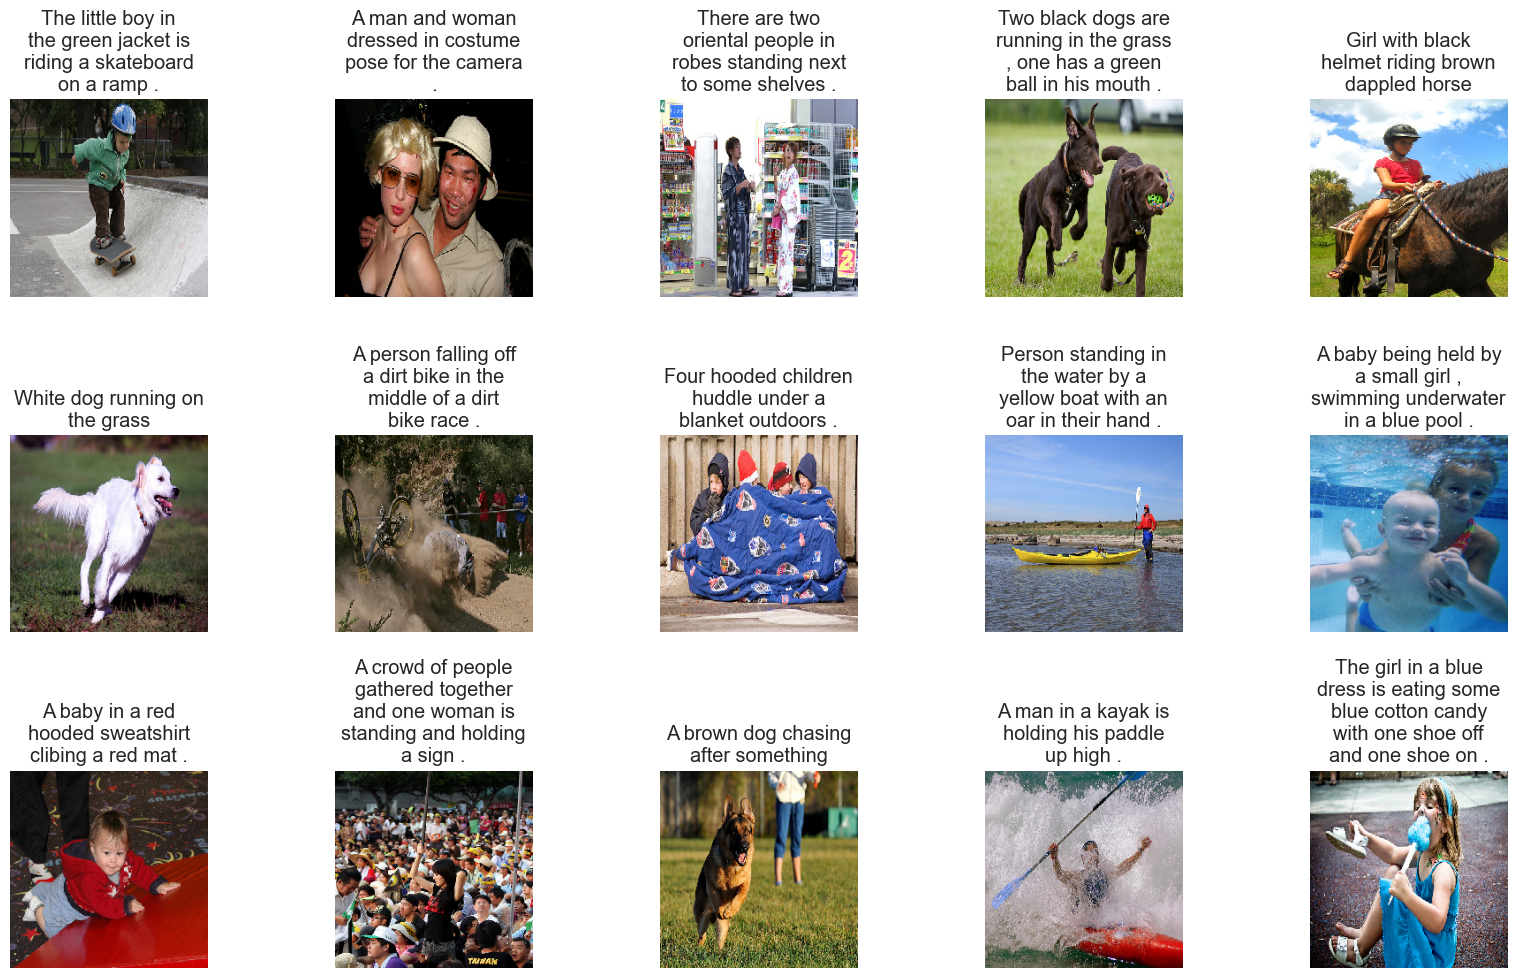

In [5]:
display_images(data.sample(15))

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rajee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Preprocessing

In [7]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def text_preprocessing(data):
    data['caption'] = data['caption'].str.lower().str.replace(r"[^a-z ]", "", regex=True)
    data['caption'] = data['caption'].str.replace(r"\s+", " ", regex=True)
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if word not in stop_words]))
    data['caption'] = data['caption'].apply(lambda x: "startseq " + x.strip() + " endseq")
    return data


In [8]:
data = text_preprocessing(data)
captions = data['caption'].tolist()

## Tokenization

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['caption'].tolist())
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(c.split()) for c in data['caption'])

# Train-test split
images = data['image'].unique()
split_index = round(0.85 * len(images))
train_images, val_images = images[:split_index], images[split_index:]

train = data[data['image'].isin(train_images)]
val = data[data['image'].isin(val_images)]

In [10]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Load InceptionV3 pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')
image_encoder = Model(inputs=base_model.input, outputs=base_model.output)

features = {}
for image in tqdm(data['image'].unique()):
    img = load_img(os.path.join(image_path, image), target_size=(299, 299))
    img = preprocess_input(img_to_array(img))
    img = np.expand_dims(img, axis=0)
    feature = image_encoder.predict(img, verbose=0)
    features[image] = feature

with open('features.pkl', 'wb') as f:
    pickle.dump(features, f)


100%|██████████| 8091/8091 [11:02<00:00, 12.21it/s]


## Data generation

In [11]:
class CustomDataGenerator(Sequence):
    def __init__(self, df, tokenizer, vocab_size, max_length, features, batch_size=32, shuffle=True):
        self.df = df.copy()
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return len(self.df) // self.batch_size

    def __getitem__(self, index):
        X1, X2, y = [], [], []
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size]

        for _, row in batch.iterrows():
            feature = self.features[row['image']][0]  # Extract feature vector
            caption = self.tokenizer.texts_to_sequences([row['caption']])[0]

            for i in range(1, len(caption)):
                in_seq = pad_sequences([caption[:i]], maxlen=self.max_length, padding='post', dtype='int32')[0]
                out_seq = to_categorical([caption[i]], num_classes=self.vocab_size)[0]

                X1.append(feature)  # Image features
                X2.append(in_seq)   # Input sequence (partial captions)
                y.append(out_seq)   # Target word

        X1 = np.array(X1, dtype=np.float32)  # Ensure float32 for image features
        X2 = np.array(X2, dtype=np.int32)    # Ensure int32 for input sequences
        y = np.array(y, dtype=np.float32)    # Ensure float32 for target words

        return (X1, X2), y


In [12]:
# Define the train generator
train_generator = CustomDataGenerator(
    df=train,                
    tokenizer=tokenizer,      
    vocab_size=vocab_size,       
    max_length=max_length,      
    features=features,  
    batch_size=32,              
    shuffle=True                 
)

# Define the validation generator
validation_generator = CustomDataGenerator(
    df=val,                     
    tokenizer=tokenizer,         
    vocab_size=vocab_size,       
    max_length=max_length,       
    features=features,           
    batch_size=32,               
    shuffle=False                
)


## Modelling

In [13]:
# Model Definition
input1 = Input(shape=(2048,), name="image_input")  # Image input
input2 = Input(shape=(max_length,), dtype='int32', name="text_input")  # Text input

# Image features
img_features = Dense(256, activation='relu')(input1)
img_features = Reshape((1, 256))(img_features)  # Reshape to align with text features

# Load GloVe embeddings
embedding_index = {}
with open("glove.6B.200d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

# Prepare embedding matrix
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    vector = embedding_index.get(word)
    if vector is not None:
        embedding_matrix[i] = vector

# Embedding layer
embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=max_length,
    trainable=False  # Freeze embeddings to avoid altering pre-trained vectors
)

# Text features
text_features = embedding_layer(input2)  # Pass text input through embedding layer
text_features = LSTM(256, return_sequences=False)(text_features)  # Process text with LSTM

# Merge image and text features
merged = add([img_features[:, 0, :], text_features])  # Merge using 'add' operation
x = Dense(128, activation='relu')(merged)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

# Compile the model
caption_model = Model(inputs=[input1, input2], outputs=output)
caption_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.00005),  # Lower learning rate
    metrics=['accuracy']  # Optional: Monitor accuracy
)



In [14]:
from tensorflow.keras.utils import plot_model

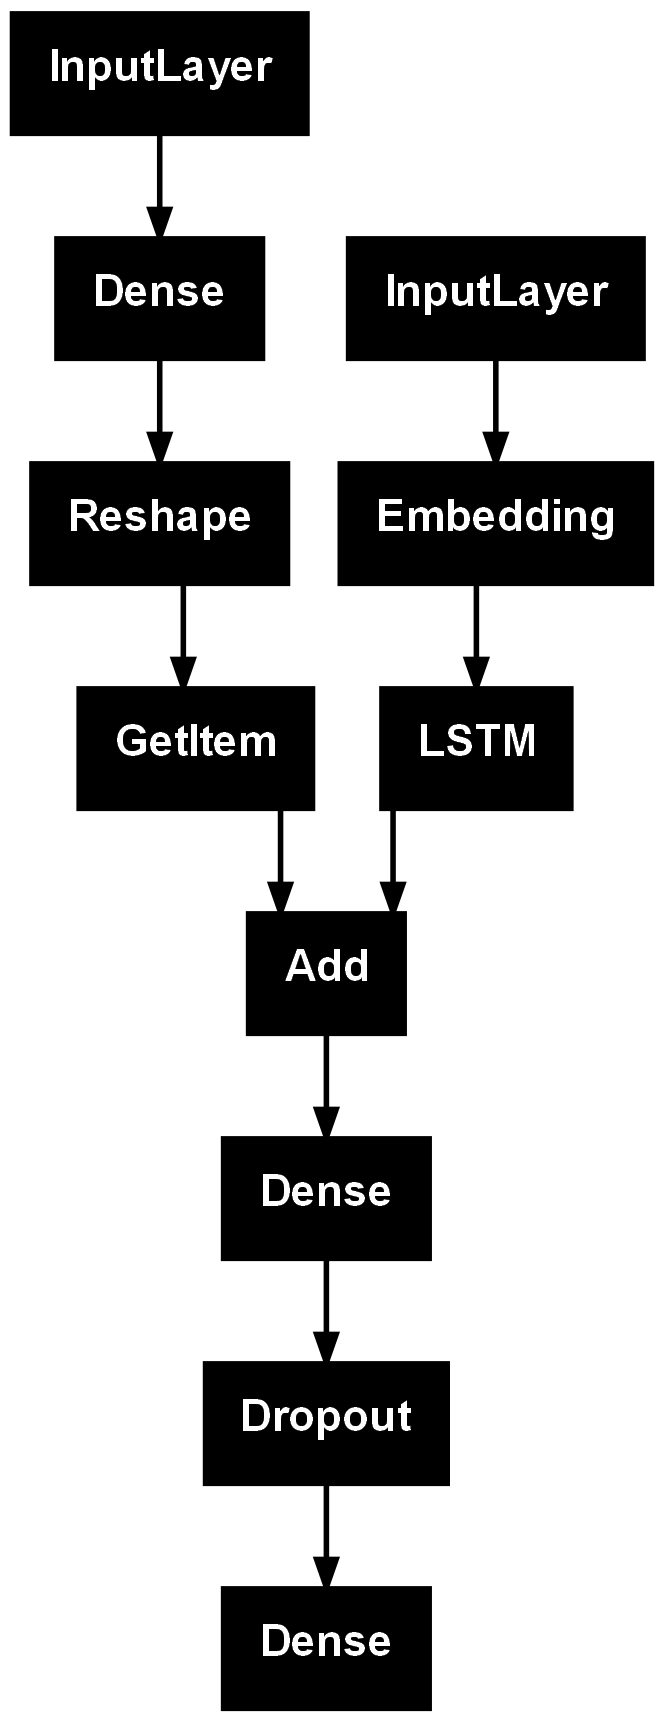

In [15]:
plot_model(caption_model)

In [16]:
caption_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ image_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 256)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 22, 200)   │  1,733,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 256)       │          0 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    467,968 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ get_item[0][0],   │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8665)      │  1,117,785 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,876,193 (14.79 MB)

 Trainable params: 2,143,193 (8.18 MB)

 Non-trainable params: 1,733,000 (6.61 MB)

In [17]:
model_name = "model-sankalp-rajeev.keras"
checkpoint = ModelCheckpoint(model_name, monitor="val_loss", save_best_only=True)
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.2, min_lr=1e-8)

In [18]:
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch, lr):
    if epoch < 5:  # Warm-up phase
        return lr * 0.5
    elif epoch < 20:
        return 0.00005
    else:
        return 0.00001  # Fine-tuning phase

lr_scheduler = LearningRateScheduler(lr_schedule)

history = caption_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[checkpoint, early_stop, lr_reduction, lr_scheduler]
)


Epoch 1/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 67s 61ms/step - accuracy: 0.1062 - loss: 7.4158 - val_accuracy: 0.1779 - val_loss: 5.8086 - learning_rate: 2.5000e-05
Epoch 2/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 65s 61ms/step - accuracy: 0.1649 - loss: 5.9159 - val_accuracy: 0.1811 - val_loss: 5.6615 - learning_rate: 1.2500e-05
Epoch 3/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 66s 62ms/step - accuracy: 0.1704 - loss: 5.7786 - val_accuracy: 0.1834 - val_loss: 5.6065 - learning_rate: 6.2500e-06
Epoch 4/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 66s 61ms/step - accuracy: 0.1742 - loss: 5.7150 - val_accuracy: 0.1847 - val_loss: 5.5827 - learning_rate: 3.1250e-06
Epoch 5/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 65s 61ms/step - accuracy: 0.1751 - loss: 5.6975 - val_accuracy: 0.1852 - val_loss: 5.5721 - learning_rate: 1.5625e-06
Epoch 6/50
1074/1074 ━━━━━━━━━━━━━━━━━━━━ 67s 62ms/step - accuracy: 0.1805 - loss: 5.5993 - val_accuracy: 0.1932 - val_loss: 5.3204 - learning_rate: 5.0000e-05
Epoch 7/50
1074/1074 ━━━━━━━━━━━━━━━━━━━

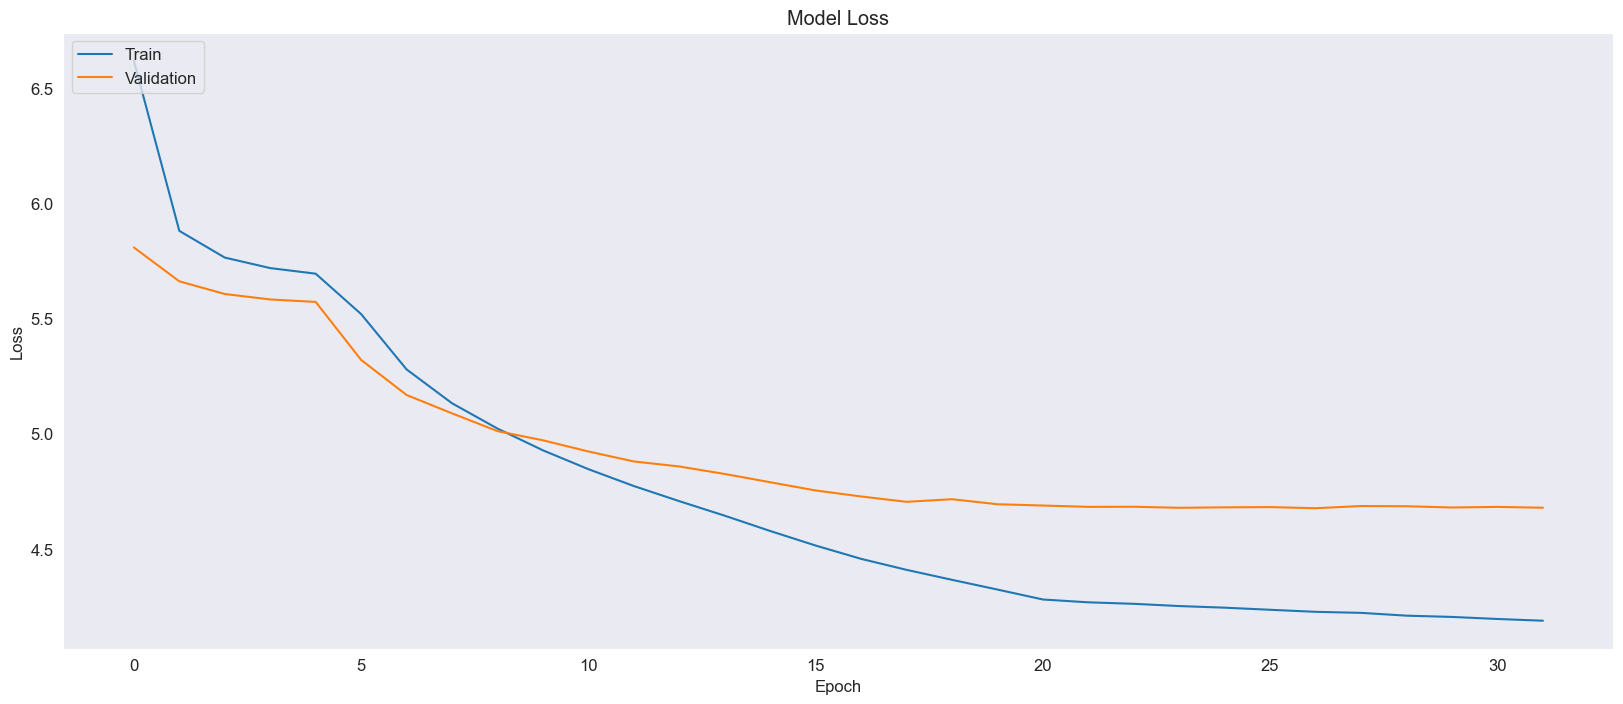

In [19]:
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [20]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [21]:
def beam_search_caption(model, image, tokenizer, max_length, features, beam_width=3):
    seqs = [([tokenizer.word_index['startseq']], 0.0)]  # Start with 'startseq' as a list
    feature = features[image]  # Extracted image feature
    completed = []

    for _ in range(max_length):
        all_candidates = []
        seen_sequences = set()  # Track unique sequences

        for seq, score in seqs:
            # Ensure seq is a list
            if not isinstance(seq, list):
                seq = [seq]

            # Stop if 'endseq' has been predicted
            if seq[-1] == tokenizer.word_index['endseq']:
                completed.append((seq, score))
                continue

            # Pad the sequence and predict
            sequence = pad_sequences([seq], maxlen=max_length, padding='post', dtype='int32')
            preds = model.predict([feature, sequence], verbose=0)[0]

            print("Top Word Mappings:")
            for idx in [6, 5, 4, 3, 2]:
                print(f"Index {idx}: {idx_to_word(idx, tokenizer)}")



            # Get the top words
            top_words = np.argsort(preds)[-beam_width:]

            for w in top_words:
                new_seq = list(seq) + [w]  # Ensure new_seq is a list
                if tuple(new_seq) not in seen_sequences:  # Avoid duplicate sequences
                    new_score = score - np.log(preds[w])  # Update log probability
                    all_candidates.append((new_seq, new_score))
                    seen_sequences.add(tuple(new_seq))

        # Sort candidates by score
        ordered = sorted(all_candidates, key=lambda x: x[1])
        seqs = ordered[:beam_width]  # Keep top beam_width sequences

        # Stop if no progress
        if not all_candidates:
            break

    # Select the best sequence
    if len(completed) > 0:
        best_seq = sorted(completed, key=lambda x: x[1])[0][0]
    else:
        best_seq = seqs[0][0]

    # Convert token indices to words
    caption = ' '.join([idx_to_word(w, tokenizer) for w in best_seq if w != tokenizer.word_index['startseq'] and w != tokenizer.word_index['endseq']])
    return caption


In [22]:
print("startseq index:", tokenizer.word_index.get('startseq'))
print("endseq index:", tokenizer.word_index.get('endseq'))


startseq index: 1
endseq index: 2


In [30]:
samples = val.sample(15).reset_index(drop=True)

In [31]:
test_image = samples.loc[0, 'image']
caption = beam_search_caption(caption_model, test_image, tokenizer, max_length, features)
print("Generated Caption:", caption)


Top Word Mappings:
Index 6: white
Index 5: two
Index 4: man
Index 3: dog
Index 2: endseq
Top Word Mappings:
Index 6: white
Index 5: two
Index 4: man
Index 3: dog
Index 2: endseq
Top Word Mappings:
Index 6: white
Index 5: two
Index 4: man
Index 3: dog
Index 2: endseq
Top Word Mappings:
Index 6: white
Index 5: two
Index 4: man
Index 3: dog
Index 2: endseq
Top Word Mappings:
Index 6: white
Index 5: two
Index 4: man
Index 3: dog
Index 2: endseq
Top Word Mappings:
Index 6: white
Index 5: two
Index 4: man
Index 3: dog
Index 2: endseq
Top Word Mappings:
Index 6: white
Index 5: two
Index 4: man
Index 3: dog
Index 2: endseq
Top Word Mappings:
Index 6: white
Index 5: two
Index 4: man
Index 3: dog
Index 2: endseq
Top Word Mappings:
Index 6: white
Index 5: two
Index 4: man
Index 3: dog
Index 2: endseq
Top Word Mappings:
Index 6: white
Index 5: two
Index 4: man
Index 3: dog
Index 2: endseq
Top Word Mappings:
Index 6: white
Index 5: two
Index 4: man
Index 3: dog
Index 2: endseq
Top Word Mappings:
In

In [32]:
print("Tokenizer Word Index Sample:")
print(list(tokenizer.word_index.items())[:10])


Tokenizer Word Index Sample:
[('startseq', 1), ('endseq', 2), ('dog', 3), ('man', 4), ('two', 5), ('white', 6), ('black', 7), ('boy', 8), ('woman', 9), ('girl', 10)]


In [33]:
for index, record in samples.iterrows():
    print(f"Processing image: {record['image']}")
    caption = beam_search_caption(caption_model, record['image'], tokenizer, max_length, features)
    print(f"Caption: {caption}")
    samples.loc[index, 'caption'] = caption

print("Generated Captions:")
print(samples[['image', 'caption']])


Processing image: 476760133_c33d2bd83d.jpg
Top Word Mappings:
Index 6: white
Index 5: two
Index 4: man
Index 3: dog
Index 2: endseq
Top Word Mappings:
Index 6: white
Index 5: two
Index 4: man
Index 3: dog
Index 2: endseq
Top Word Mappings:
Index 6: white
Index 5: two
Index 4: man
Index 3: dog
Index 2: endseq
Top Word Mappings:
Index 6: white
Index 5: two
Index 4: man
Index 3: dog
Index 2: endseq
Top Word Mappings:
Index 6: white
Index 5: two
Index 4: man
Index 3: dog
Index 2: endseq
Top Word Mappings:
Index 6: white
Index 5: two
Index 4: man
Index 3: dog
Index 2: endseq
Top Word Mappings:
Index 6: white
Index 5: two
Index 4: man
Index 3: dog
Index 2: endseq
Top Word Mappings:
Index 6: white
Index 5: two
Index 4: man
Index 3: dog
Index 2: endseq
Top Word Mappings:
Index 6: white
Index 5: two
Index 4: man
Index 3: dog
Index 2: endseq
Top Word Mappings:
Index 6: white
Index 5: two
Index 4: man
Index 3: dog
Index 2: endseq
Top Word Mappings:
Index 6: white
Index 5: two
Index 4: man
Index 3

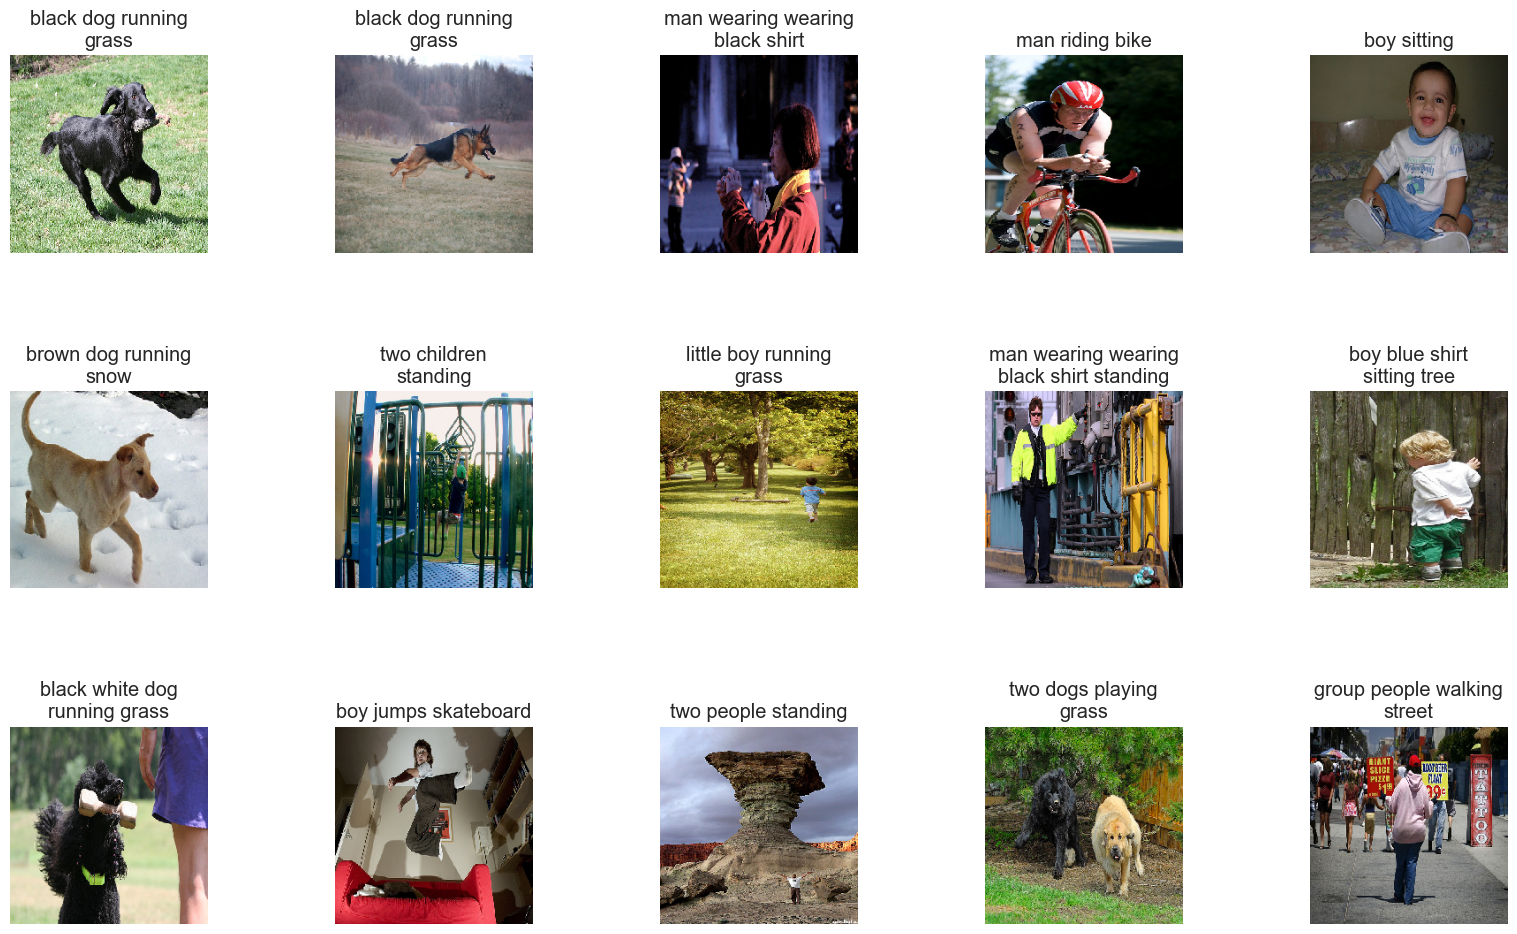

In [34]:
display_images(samples)